In [59]:
import os, fiona, glob
import geopandas as gpd
import pandas as pd

In [3]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.233333, -80.133333, 37.916667, -81.666667] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_data' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

In [67]:
dir = f'{PATH}/{PROJ_TITLE}/GeoDatabases'
path_list = glob.glob(f'{dir}/*.zip')
master_dip_gdf = gpd.GeoDataFrame()
master_geol_gdf = gpd.GeoDataFrame()
for path in path_list:
    valid_layers = []
    try:
        layers = fiona.listlayers(path)
        for layer in layers:
            if 'BED' in layer:
                valid_layers.append(layer)
            if 'CNT_poly' in layer or 'CNT_POLY' in layer:
                valid_layers.append(layer)
            gdf = gpd.read_file(path, layer=valid_layers[0])
            gdf.columns = gdf.columns.str.lower()
            master_dip_gdf = pd.concat([master_dip_gdf, gdf], ignore_index=True)
            try:
                gdf2 = gpd.read_file(path, layer = valid_layers[1])
                gdf2.columns = gdf2.columns.str.lower()
                master_geol_gdf= pd.concat([master_geol_gdf, gdf2], ignore_index=True)
            except Exception as e:
                print(f'No geology layer, {e}')
    except Exception as e:
        print(f'An error occured: {e}')

An error occured: Failed to open dataset (flags=68): /sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_data/GeoDatabases/DDS-10_FrontRoyal100K_GeMS_lvl3.zip
An error occured: list index out of range
No geology layer, list index out of range
An error occured: Failed to open dataset (flags=68): /sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_data/GeoDatabases/DDS-9_Cumberland100K_GeMS_Lvl3.zip
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
An error occured: list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geolog

<Axes: >

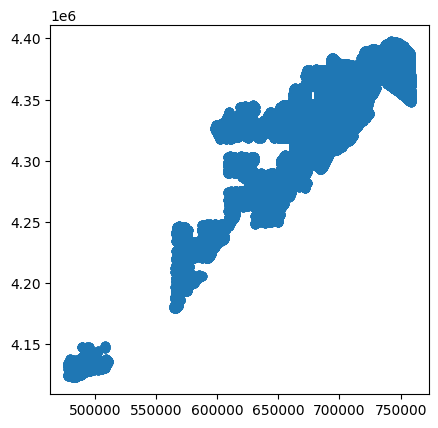

In [89]:
master_dip_gdf = master_dip_gdf[['dip_angle', 'dip_direct', "geometry"]]
master_dip_gdf.plot()

In [79]:
master_geol_gdf = master_geol_gdf[['unit_abbrv', 'geometry', 'symbol']]
display(master_geol_gdf)

,unit_abbrv,geometry,symbol
0,Dmt,"MULTIPOLYGON (((742355.166 4397808.605, 742353...",NaN
1,Dbh,"MULTIPOLYGON (((743157.976 4397684.062, 743156...",NaN
2,Dmn,"MULTIPOLYGON (((730854.298 4369747.316, 730716...",NaN
3,Dbh,"MULTIPOLYGON (((747698.404 4396570.638, 747687...",NaN
4,Do,"MULTIPOLYGON (((730716.118 4369851.313, 730566...",NaN
...,...,...,...
16270,Dbh,"MULTIPOLYGON (((697389.195 4360370.402, 697389...",NaN
16271,Dgg,"MULTIPOLYGON (((699361.851 4359808.543, 699353...",NaN
16272,Dhs,"MULTIPOLYGON (((700604.406 4358161.215, 700563...",NaN
16273,Dgg,"MULTIPOLYGON (((702160.66 4359194.61, 702147.5...",NaN


In [91]:
from pyproj import Proj, transform
import numpy as np

ksn_paths = glob.glob(f'{PATH}/{PROJ_TITLE}/ksn_csvs/*.csv')
for csv in ksn_paths:
    csv_name = csv.split(sep='/')[-1]
    wshed_name = csv_name[0:-23]
    ksn_df = pd.read_csv(csv, index_col=0)
    delta_ksn = np.abs(np.asarray(ksn_df['delta_ksn']))
    high_ksn = [x > np.percentile(delta_ksn, 90) for x in delta_ksn]
    ksn_df['kp'] = high_ksn
    in_proj = Proj(init='epsg:2283')
    out_proj = Proj(init='epsg:4269')
    easting = ksn_df.x.values
    northing = ksn_df.y.values
    longitude, latitude = transform(in_proj, out_proj, easting, northing)
    ksn_df['longitude'] = longitude
    ksn_df['latitude'] = latitude
    ksn_df['wshed'] = [wshed_name]*len(ksn_df)
    ksn_df_masked = ksn_df[ksn_df.kp == True][['chi', 'delta_ksn', 'elevation', 'x', 'y', 'longitude', 'latitude', 'wshed']]
    final_kp_df = gpd.GeoDataFrame(data=ksn_df_masked, geometry= gpd.points_from_xy(ksn_df_masked.x, ksn_df_masked.y))
    display(gpd.sjoin_nearest(final_kp_df, master_dip_gdf, max_distance= 10, distance_col='dist_from_dip'))
    display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol


/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/sciclone/home/ntlewis/Nick-Lewis-Research/.venv/lib64/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,dip_angle,dip_direct,dist_from_dip


/local/scr/ntlewis/TMPDIR/ipykernel_3282209/3897282159.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:26917

  display(gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=10, distance_col='dist_from_geol'))


,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol
